In [160]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Gray Scale Conversion

In [161]:
def load_and_convert_images(image_path):
    """
    Load an image from the given path and convert it to grayscale
    if it's not already grayscale.
    """
    # Load the image
    image = cv2.imread(image_path)
    
    # Check if the image is already grayscale
    if len(image.shape) == 3:  # If the image has 3 channels, it's in color (BGR)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:  # Image is already in grayscale
        gray = image
    
    return image, gray

# SIFT Keypoints

In [162]:
def detect_and_compute_sift(gray1, gray2):
    """
    Detect keypoints and compute descriptors using SIFT.
    """
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)
    return keypoints1, descriptors1, keypoints2, descriptors2

# Brute force matching

In [163]:
def match_features(descriptors1, descriptors2):
    """
    Match descriptors using BFMatcher, apply 1NN/2NN ratio test, and perform cross-validation.
    """
    bf = cv2.BFMatcher()
    matches_12 = bf.knnMatch(descriptors1, descriptors2, k=2)  # Match from img1 to img2
    matches_21 = bf.knnMatch(descriptors2, descriptors1, k=2)  # Match from img2 to img1
    
    good_matches = []
    
    for m, n in matches_12:
        # Apply the 1NN/2NN ratio test
        if m.distance < 0.75 * n.distance:
            query_idx = m.queryIdx
            train_idx = m.trainIdx

            # Perform cross-validation check (reverse matching)
            reverse_matches = [rm for rm, rn in matches_21 if rm.queryIdx == train_idx and rm.trainIdx == query_idx]
            if reverse_matches:
                good_matches.append(m)
    
    return good_matches

# Matched Keypoints

In [164]:
def extract_matched_points(keypoints1, keypoints2, matches):
    """
    Extract matched keypoints from the images based on matches.
    """
    points1 = np.array([keypoints1[m.queryIdx].pt for m in matches])
    points2 = np.array([keypoints2[m.trainIdx].pt for m in matches])
    return points1, points2

# Normalizing Points
### 1. Centroid Calculation
The centroid of the points is calculated as:
$$
\text{centroid} = \frac{1}{n} \sum_{i=1}^{n} \mathbf{p}_i
$$
where $ \mathbf{p}_i = [x_i, y_i] $ is the $i$-th point and $n$ is the total number of points. The centroid is essentially the mean of the $x$ and $y$ coordinates of all points.

### 2. Shifting Points to the Origin
Next, the points are shifted so that the centroid is at the origin. This is done by subtracting the centroid from each point:
$$
\mathbf{p}_i^{\text{centered}} = \mathbf{p}_i - \text{centroid}
$$
where $ \mathbf{p}_i^{\text{centered}} = [x_i - \text{centroid}_x, y_i - \text{centroid}_y] $.

### 3. Compute the Average Distance from the Origin
The average distance of the points from the origin (after centering) is computed as:
$$
\text{avg\_distance} = \frac{1}{n} \sum_{i=1}^{n} \sqrt{(x_i^{\text{centered}})^2 + (y_i^{\text{centered}})^2}
$$
This gives the average Euclidean distance of the points from the origin.

### 4. Scaling
To improve numerical stability, we scale the points such that the average distance from the origin is $ \sqrt{2} $. The scaling factor is calculated as:
$$
\text{scale} = \frac{\sqrt{2}}{\text{avg\_distance}}
$$
This factor ensures that the normalized points are scaled uniformly.

The normalized points are then computed as:
$$
\mathbf{p}_i^{\text{normalized}} = \mathbf{p}_i^{\text{centered}} \times \text{scale}
$$
This step ensures that the average distance of the normalized points from the origin is $ \sqrt{2} $.

### 5. Normalization Matrix
The normalization transformation can be represented as a matrix $ T $. The matrix $ T $ performs the scaling and the translation:
$$
T = \begin{bmatrix}
\text{scale} & 0 & -\text{scale} \times \text{centroid}_x \\
0 & \text{scale} & -\text{scale} \times \text{centroid}_y \\
0 & 0 & 1
\end{bmatrix}
$$
This 3x3 matrix applies both the scaling and the translation to move the centroid to the origin and scale the points.


In [165]:
def normalize_points(points):
    """
    Normalize the points to improve numerical stability.
    """
    # Compute the centroid
    centroid = np.mean(points, axis=0)
    # Shift points to the origin
    points_centered = points - centroid
    # Compute the average distance from the origin
    avg_distance = np.mean(np.sqrt(np.sum(points_centered**2, axis=1)))
    # Scale points so that the average distance is sqrt(2)
    scale = np.sqrt(2) / avg_distance
    points_normalized = points_centered * scale
    # Create the normalization matrix
    T = np.array([[scale, 0, -scale * centroid[0]],
                  [0, scale, -scale * centroid[1]],
                  [0, 0, 1]])
    return points_normalized, T

# Fundamental Matrix Denormalization

In [166]:
def denormalize_fundamental_matrix(F_normalized, T1, T2):
    """
    Denormalize the fundamental matrix.
    """
    F = T1.T @ F_normalized @ T2
    return F


# Fundamental Matrix(F)

In [167]:
def compute_fundamental_matrix_8point(points1, points2):
    """
    Compute the fundamental matrix using the 8-point algorithm.
    """
    # Normalize points
    points1_normalized, T1 = normalize_points(points1)
    points2_normalized, T2 = normalize_points(points2)
    
    # Construct the matrix A
    A = np.zeros((len(points1), 9))
    for i in range(len(points1)):
        x1, y1 = points1_normalized[i]
        x2, y2 = points2_normalized[i]
        A[i] = [x2* x1, x2 * y1, x2, y2 * x1, y2 * y1, y2, x1, y1, 1]
    
    # Compute SVD of A
    _, _, Vt = np.linalg.svd(A)
    F_normalized = Vt[-1].reshape(3, 3)
    
    # Enforce rank-2 constraint
    U, S, Vt = np.linalg.svd(F_normalized)
    S[2] = 0
    F_normalized = U @ np.diag(S) @ Vt
    
    # Denormalize the fundamental matrix
    F = denormalize_fundamental_matrix(F_normalized, T1, T2)
    
    return F

# RANSAC

In [168]:
def compute_inliers_ransac(points1, points2, threshold, iterations=1000):
    """
    Use RANSAC to estimate the fundamental matrix and identify inliers.
    """
    best_inliers = []
    best_F = None
    max_inliers = 0

    for _ in range(iterations):
        # Step 1: Randomly select 8 points
        idx = np.random.choice(len(points1), 8, replace=False)
        pts1_sample = points1[idx]
        pts2_sample = points2[idx]

        # Step 2: Estimate the fundamental matrix using 8-point algorithm
        F_candidate = compute_fundamental_matrix_8point(pts1_sample, pts2_sample)

        # Step 3: Epipolar constraint: x2.T * F * x1 = 0
        ones = np.ones((points1.shape[0], 1))
        pts1_homog = np.hstack((points1, ones))
        pts2_homog = np.hstack((points2, ones))
        error = np.abs(np.sum(pts2_homog * (F_candidate @ pts1_homog.T).T, axis=1))

        # Step 4: Count inliers (where error < threshold)
        inliers = np.where(error < threshold)[0]

        if len(inliers) > max_inliers:
            max_inliers = len(inliers)
            best_inliers = inliers
            best_F = F_candidate

    # Recalculate F using all inliers
    F_ransac = compute_fundamental_matrix_8point(points1[best_inliers], points2[best_inliers])
    
    return F_ransac, best_inliers

# Epipolar Lines

In [169]:
def compute_epipolar_lines_formula(F, points, which_image):
    """
    Compute epipolar lines using the fundamental matrix manually via the formula.
    For points in image 1, use F. For points in image 2, use F.T.
    """
    lines = []
    for point in points:
        # Convert point to homogeneous coordinates
        x, y = point
        point_homogeneous = np.array([x, y, 1])
        if which_image == 1:
            # Compute the line in image 2: l2 = F * x1
            line = F @ point_homogeneous
        else:
            # Compute the line in image 1: l1 = F.T * x2
            line = F.T @ point_homogeneous
        lines.append(line)
    return np.array(lines)


In [170]:
def compute_epipolar_lines(F, points, image_shape, which_image):
    """
    Compute the epipolar lines in one image given points from the other image.
    """
    lines = cv2.computeCorrespondEpilines(points.reshape(-1, 1, 2), which_image, F)
    lines = lines.reshape(-1, 3)
    return lines


# Draw lines

In [171]:
def draw_epipolar_lines(img1, lines, pts1, pts2):
    """
    Draw epipolar lines on the images.
    """
    img1_copy = img1.copy()
    
    # Drawing the lines on both images
    r, c = img1.shape[:2]
    
    # Draw lines and points for image 1
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        
        # Convert point coordinates to integers
        pt1 = tuple(map(int, pt1))  # Convert pt1 to integer tuple
        pt2 = tuple(map(int, pt2))  # Convert pt2 to integer tuple

        # Calculate line endpoints
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        
        # Draw the epipolar line and the points
        img1_copy = cv2.line(img1_copy, (x0, y0), (x1, y1), color, 1)
        img1_copy = cv2.circle(img1_copy, pt1, 5, color, -1)
    
    return img1_copy


# Image Display

In [172]:
def display_images(img1, img2):
    """
    Display the images with epipolar lines.
    """
    plt.figure(figsize=(12, 6))
    plt.subplot(121), plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)), plt.title('Left Image with Epipolar Lines')
    plt.subplot(122), plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)), plt.title('Right Image with Epipolar Lines')
    plt.show()


In [173]:
def process(image1_path,image2_path):
    image1, gray1 = load_and_convert_images(image1_path)
    image2, gray2 = load_and_convert_images(image2_path)
    
    # Detect and compute SIFT features
    keypoints1, descriptors1, keypoints2, descriptors2 = detect_and_compute_sift(gray1, gray2)
    
    # Match features
    matches = match_features(descriptors1, descriptors2)
    
    # Extract matched points
    points1, points2 = extract_matched_points(keypoints1, keypoints2, matches)

    
    # Compute the fundamental matrix using 8-point algorithm
    F_ransac, inliers = compute_inliers_ransac(points1, points2, threshold=0.01)
    print("Fundamental Matrix (8-point algorithm & RANSAC):\n", F_ransac)
# Compute epipolar lines for the RANSAC fundamental matrix
    lines1 = compute_epipolar_lines(F_ransac, points2[inliers], image1.shape[::-1], 2)
    lines2 = compute_epipolar_lines(F_ransac, points1[inliers], image2.shape[::-1], 1)

    
    # Draw epipolar lines
    img1_with_lines_8point = draw_epipolar_lines(image1,  lines1, points1, points2)
    img2_with_lines_8point = draw_epipolar_lines(image2,  lines2, points1, points2)
 
    
    # Display images
    display_images(img1_with_lines_8point, img2_with_lines_8point)


# Compute epipolar lines for the RANSAC fundamental matrix using manual formula
    lines1 = compute_epipolar_lines_formula(F_ransac, points2[inliers], 2)
    lines2 = compute_epipolar_lines_formula(F_ransac, points1[inliers], 1)

    
      # Draw epipolar lines
    img1_with_lines_8point = draw_epipolar_lines(image1,  lines1, points1, points2)
    img2_with_lines_8point = draw_epipolar_lines(image2,  lines2, points1, points2)
 
    
    # Display images
    display_images(img1_with_lines_8point, img2_with_lines_8point)

In [174]:
def process1(image1_path,image2_path):
    image1, gray1 = load_and_convert_images(image1_path)
    image2, gray2 = load_and_convert_images(image2_path)
    
    # Detect and compute SIFT features
    keypoints1, descriptors1, keypoints2, descriptors2 = detect_and_compute_sift(gray1, gray2)
    
    # Match features
    matches = match_features(descriptors1, descriptors2)
    
    # Extract matched points
    points1, points2 = extract_matched_points(keypoints1, keypoints2, matches)

    F_8point = compute_fundamental_matrix_8point(points1, points2)
    print("Fundamental Matrix (8-point algorithm):\n", F_8point)
    
   
# Compute epipolar lines for the RANSAC fundamental matrix
    lines1 = compute_epipolar_lines(F_8point, points2, image1.shape[::-1], 2)
    lines2 = compute_epipolar_lines(F_8point, points1, image2.shape[::-1], 1)

    
    # Draw epipolar lines
    img1_with_lines_8point = draw_epipolar_lines(image1,  lines1, points1, points2)
    img2_with_lines_8point = draw_epipolar_lines(image2,  lines2, points1, points2)
 
    
    # Display images
    display_images(img1_with_lines_8point, img2_with_lines_8point)


# Compute epipolar lines for the RANSAC fundamental matrix using manual formula
    lines1 = compute_epipolar_lines_formula(F_8point, points2, 2)
    lines2 = compute_epipolar_lines_formula(F_8point, points1, 1)

    
      # Draw epipolar lines
    img1_with_lines_8point = draw_epipolar_lines(image1,  lines1, points1, points2)
    img2_with_lines_8point = draw_epipolar_lines(image2,  lines2, points1, points2)
 
    
    # Display images
    display_images(img1_with_lines_8point, img2_with_lines_8point)

Fundamental Matrix (8-point algorithm & RANSAC):
 [[-1.95380026e-21 -7.47665342e-05  1.94566466e-02]
 [ 7.47665342e-05  8.72511930e-21 -1.74204874e-02]
 [-1.94566466e-02  1.74204874e-02  1.03250741e-14]]


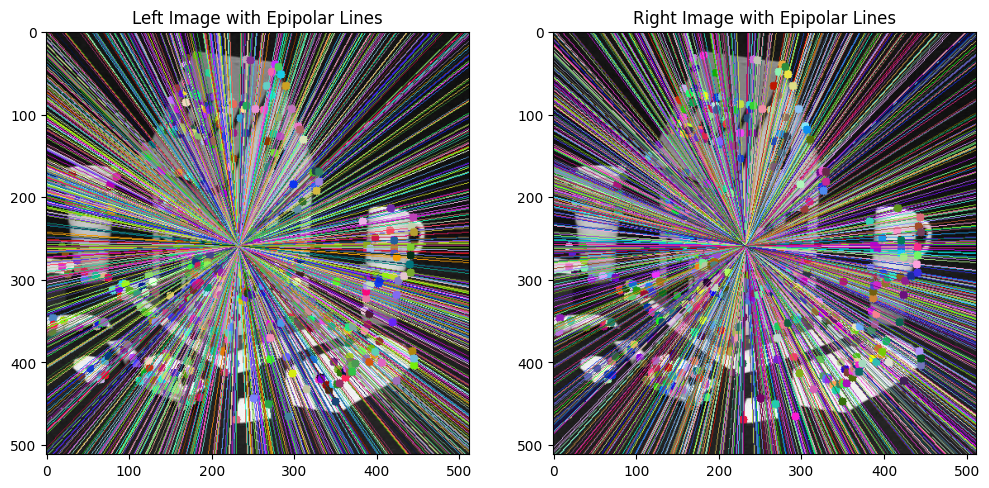

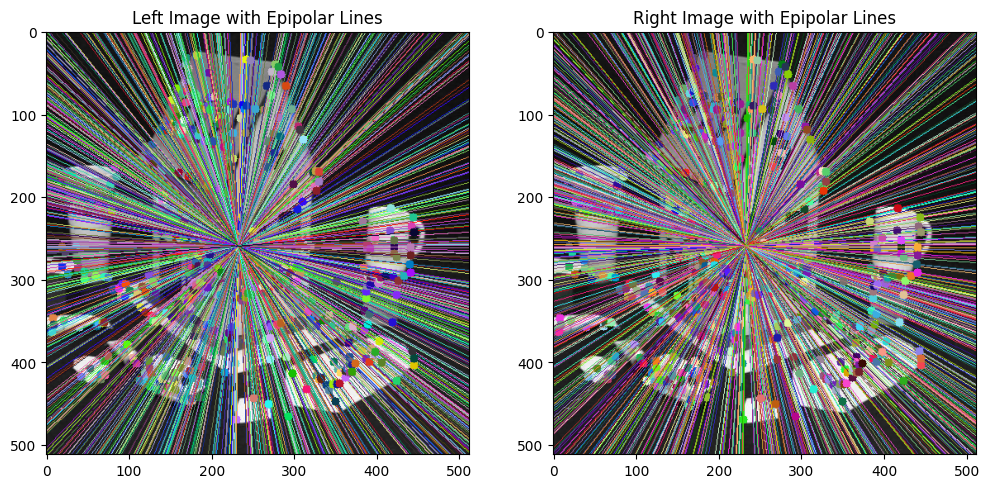

Fundamental Matrix (8-point algorithm):
 [[-1.95380026e-21 -7.47665342e-05  1.94566466e-02]
 [ 7.47665342e-05  8.72511930e-21 -1.74204874e-02]
 [-1.94566466e-02  1.74204874e-02  1.03250741e-14]]


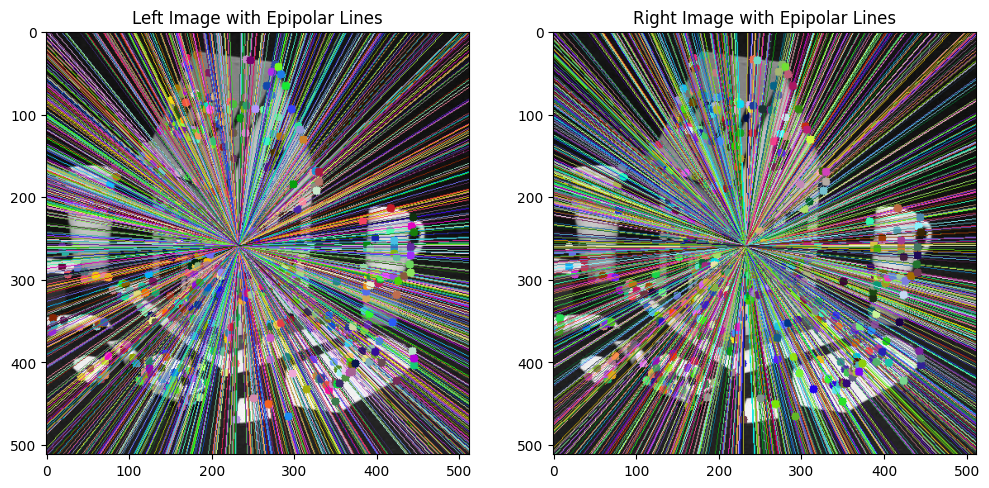

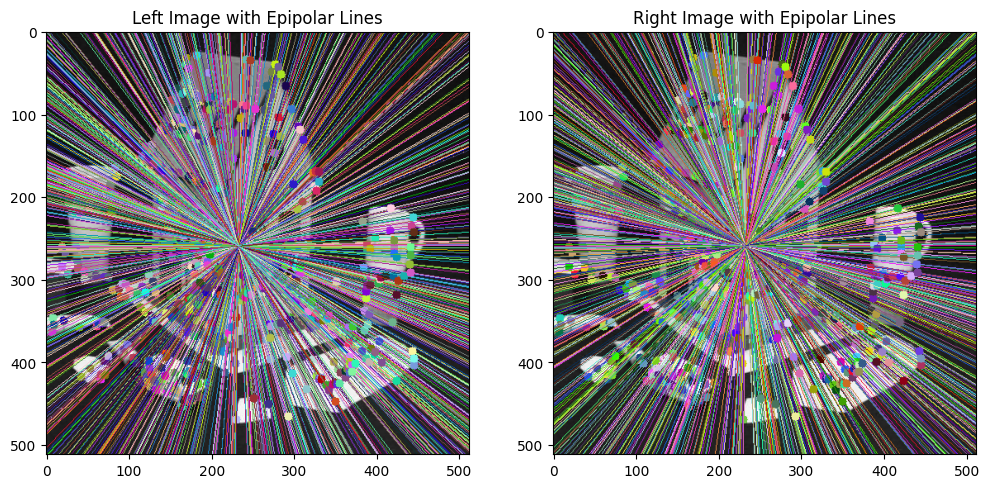

In [175]:
image1_path = 'U:\\Final Year Project\\FYP-2\\Tasks\\3. Epi polar Geomatry\\3) Epipolar Geometry & 8-Point Algorithm\\images\\image_left.jpg'
image2_path = 'U:\\Final Year Project\\FYP-2\\Tasks\\3. Epi polar Geomatry\\3) Epipolar Geometry & 8-Point Algorithm\\images\\image_left.jpg'

process(image1_path,image2_path)

process1(image1_path,image2_path)